# ANÁLISIS DEL DATASET MERCARI PRICE

Vamos a trabajar con un dataset que contiene información de un listado de productos
(Fuente: https://www.kaggle.com/c/mercari-price-suggestion-challenge/data, archivo: train.tsv),  con los siguientes atributos: <br/>
<ol>
<li>train_id: El identificador del listado</li>
<li>name: título de la lista. </li>
<li>item_condition_id: La condición del producto provisto por el vendedor.</li>
<li>category_name: Categoría del listado.</li>
<li>brand_name: Marca del producto.</li>
<li>price: El precio al que fue vendido el producto. </li>
<li>shipping: 1-si el cargo de envío es pagado por el vendedor y 0 si es pagado por el comprador.</li>
<li>item_description: Descripción del producto.</li>
</ol>

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ggplot import *
import squarify
from wordcloud import WordCloud


## Lectura de los datos:</br>
1.- Leer el fichero train.csv en un dataframe


In [2]:
train_1 = pd.read_csv("", delimiter='\t')

## Limpieza y transformación de los datos:</br>
2.- ¿Todos los atributos o columnas son relevantes para el análisis?


Exploramos la estructura de los datos:

In [3]:
train_1.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
print (train_1.shape)

(1482535, 8)


El archivo está formado por 1482535 filas que conforman el listado de productos y 8 columnas. La columna train_id no aporta una característica del listado y resulta contener el mismo valor que el índice de fila. Podemos eliminar esta columna: 

In [5]:
del train_1['train_id']

In [6]:
train_1.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


3.- Identiﬁca las columnas en las que hay valores nulos y qué porcentaje representan

In [7]:
print ("Las columnas con valores nulos son:\n",train_1.isnull().sum()[train_1.isnull().sum()>0])

Las columnas con valores nulos son:
 category_name         6327
brand_name          632682
item_description         4
dtype: int64


In [8]:
print ("Porcentaje de Nulos por columna: \n", train_1.isnull().sum()/len (train_1)*100)

Porcentaje de Nulos por columna: 
 name                  0.000000
item_condition_id     0.000000
category_name         0.426769
brand_name           42.675687
price                 0.000000
shipping              0.000000
item_description      0.000270
dtype: float64


In [9]:
sin_des=train_1[train_1['item_description']=="No description yet"]['item_description'].count()
print(sin_des, sin_des/len(train_1)*100)

82489 5.5640507644


Cerca de la mitad de los artículos están registrados sin marca. Menos del 1% de los artículos no registran categoría y solo 4 artículos no registran descripción. Pero revisando la columna item_descripción, además encontramos que hay 82489 artículos con "No description yet", es decir sin descripción.

4.- Completa los valores nulos de manera conveniente

In [10]:
train_1["brand_name"]=train_1["brand_name"].fillna("NoBrand")
train_1["category_name"]=train_1["category_name"].fillna("other/other/other")
train_1['item_description']=train_1["item_description"].fillna("No description yet")

5.- ¿Cómo estás categorizados los productos? ¿Qué valores tienen esas variables? </br>
La variable category_name está compuesta por tres o cuatro niveles (menor cantidad) de jerarquía de categorías separados por '/'. Para el análisis vamos a separar esta columna en tres columnas nuevas.

In [11]:
s=pd.DataFrame(dict(zip(range(3), [train_1['category_name'].apply(lambda x : x.split('/')[i]) for i in range(3)]))) 
s.rename(columns={0:'cat_gen', 1:'subcat_1',2:'subcat_2'}, inplace = True)
train_2 = pd.concat([train_1, s],axis=1)
del train_2['category_name']

In [12]:
train_2.head()

,name,item_condition_id,brand_name,price,shipping,item_description,cat_gen,subcat_1,subcat_2
0,MLB Cincinnati Reds T Shirt Size XL,3,NoBrand,10.0,1,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,NoBrand,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,NoBrand,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [13]:
print("Hay %d categorías únicas en el primer nivel." % train_2['cat_gen'].nunique())
print("Hay %d subcategorías únicas en el segundo nivel." % train_2['subcat_1'].nunique())
print("Hay %d subcategorías únicas en el tercer nivel." % train_2['subcat_2'].nunique())

Hay 11 categorías únicas en el primer nivel.
Hay 114 subcategorías únicas en el segundo nivel.
Hay 871 subcategorías únicas en el tercer nivel.


## Análisis de los datos:</br>
6.- ¿Cuántos árticulos hay en las categorias superiores? ¿Cuáles son las categorías más populares y cuál es su precio promedio?


Cantidad de artículos por categoría superior

In [26]:
train_2['cat_gen'].value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
other                       6327
Name: cat_gen, dtype: int64

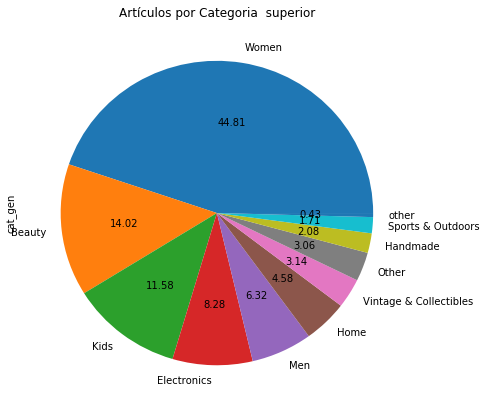

In [61]:
% matplotlib inline
train_2['cat_gen'].value_counts().plot(kind='pie', autopct='%.2f', figsize=(7, 7), title='Artículos por Categoria  superior');

Precio promedio de los artículos por Categoría Superior

In [71]:
percat=train_2.groupby("cat_gen").price
percat.agg([np.mean,np.std,np.max,np.median])

,mean,std,amax,median
cat_gen,,,,
Beauty,19.671536,21.360135,2000.0,15.0
Electronics,35.173922,65.419784,1909.0,15.0
Handmade,18.156572,27.758289,1750.0,12.0
Home,24.536599,24.417061,848.0,18.0
Kids,20.642315,22.730876,809.0,14.0
Men,34.708614,41.240057,1309.0,21.0
Other,20.809817,29.847758,1400.0,14.0
Sports & Outdoors,25.532219,29.302234,915.0,16.0
Vintage & Collectibles,27.339426,53.507495,1709.0,16.0


Las Categorías superiores son 10 y los más populares en el listado son: Women (44.81% ) y Beauty, seguido de Kids y Electronics.
Se puede observar que las categorías Electronics y Men son los que tienen un precio promedio mayor, y los artículos Handmade los de menor precio promedio. Además el precio de la categoría Electronic tiene una alta desviación estadar lo que indica una mayor variabilidad en los precios lo cual haría que el precio promedio no sea un buen representante de la categoría.

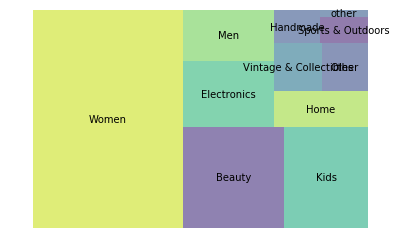

In [42]:
squarify.plot(sizes=train_2['cat_gen'].value_counts(), label=train_2['cat_gen'].value_counts().index, alpha=.6 )
plt.axis('off')
plt.show()


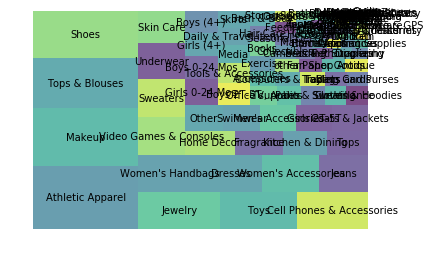

In [53]:
squarify.plot(sizes=train_2['subcat_1'].value_counts(), label=train_2['subcat_1'].value_counts().index, alpha=.7 )
plt.axis('off')
plt.show()

En la subcategoría 1, las más populares en el listado son: Shoes, Tops & Blouses, Makeup y Athetic Apparel.

In [ ]:
7. ¿Cuál es la distribución del precio?

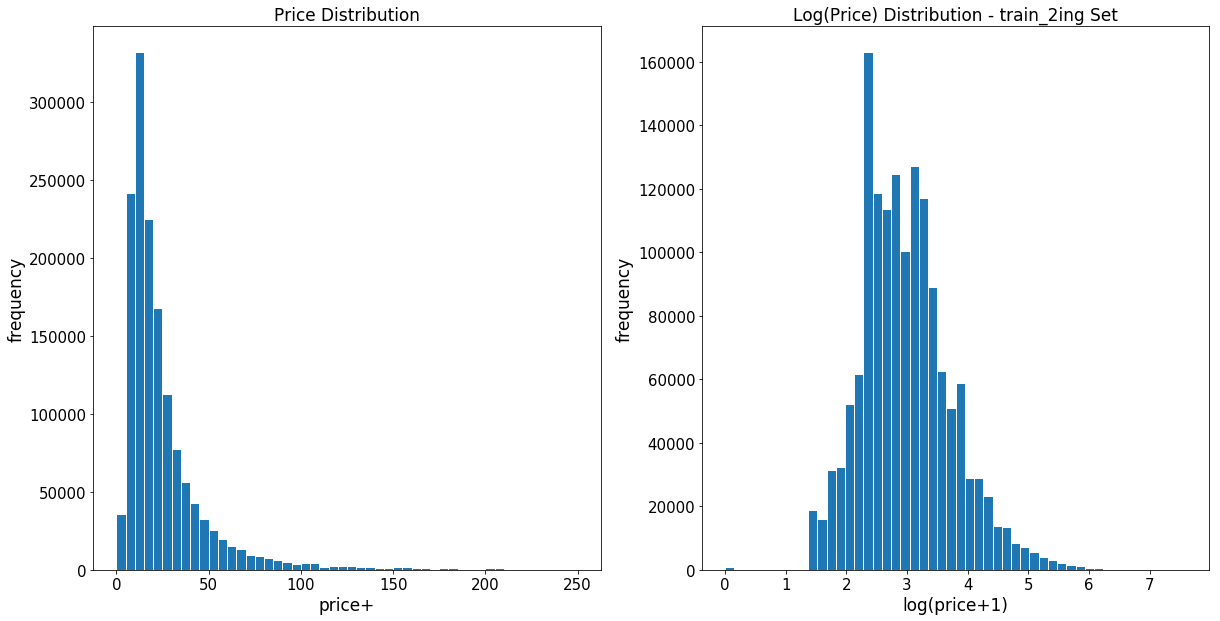

In [62]:
plt.subplot(1, 2, 1)
(train_2['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price', fontsize=17)
plt.ylabel('frequencia', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Distribución del Precio', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train_2['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequencia', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('distribución del logaritmo del Precio', fontsize=17)
plt.show()

El precio sigue una distribución sesgada hacia los valores menores de 100, qués es donde se 
concentra la mayor cantidad de artículos. Existen algunos valores extremos que afetan los valores promedios de los precios.
La gráfica de la distribución del log (precio+1) tienen una distribucón más cercana a la normal.

8.- ¿Qué relación tiene el precio con las condiciones de envío (shipping) y la condición del artículo? </br>

Condición del Artículo y Precio

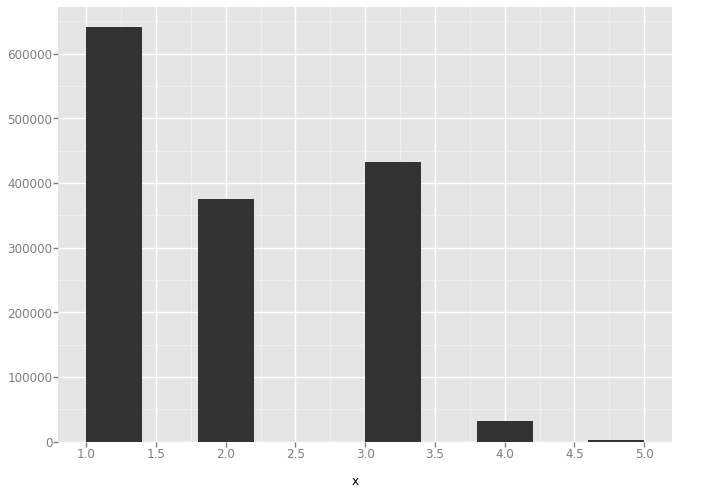

<ggplot: (-9223371931112476991)>

In [86]:
qplot(train_2["item_condition_id"], geom="hist")

In [87]:
train_2.pivot_table("price",aggfunc ="median",index="cat_gen",columns=["item_condition_id"], margins=True)

item_condition_id,1,2,3,4,5,All
cat_gen,,,,,,
Beauty,15.0,15.0,15.0,12.0,10.0,15.0
Electronics,12.0,19.0,19.0,24.0,25.0,15.0
Handmade,10.0,14.0,16.0,14.0,11.0,12.0
Home,20.0,16.0,16.0,13.0,14.0,18.0
Kids,15.0,14.0,14.0,13.0,14.0,14.0
Men,25.0,21.0,20.0,20.0,21.0,21.0
Other,13.0,14.0,14.0,13.0,14.0,14.0
Sports & Outdoors,16.0,17.0,18.0,16.0,18.0,16.0
Vintage & Collectibles,17.0,14.0,16.0,16.0,14.0,16.0


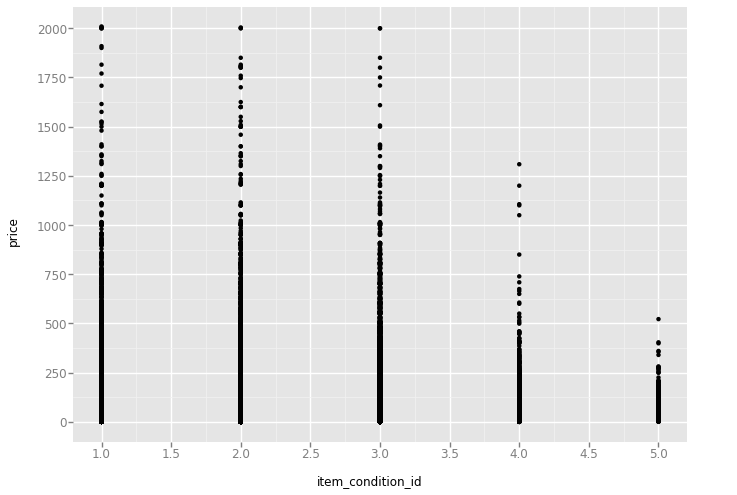

<ggplot: (105742350014)>

In [88]:
ggplot(train_2, aes('item_condition_id', 'price')) + geom_point()

En el listado se tienen artículos de condición 1,2 y 3 en mayor proporción, entendiendo que 1 en mejor condición y 5 lo opuesto.
Los precios son mayores para los productos con mejor condición con excepciones, Esta excepción se puede observar en la categoría Electronics donde se observa precios promedios menores para condiciones mejores de los artículos. 

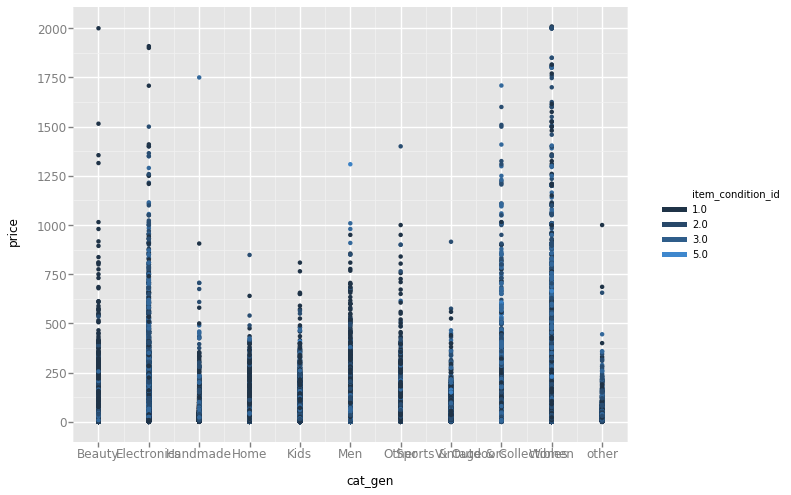

<ggplot: (105742349832)>

In [89]:
qplot(data=train_2, x="cat_gen", y="price", color="item_condition_id")

Condiciones de Envío y Precio <br/>


In [113]:
print ("Cantidad de artículos por tipo de envío:")
print(pd.value_counts(train_2.shipping)/len (train_2)*100)

Cantidad de artículos por tipo de envío:
0    55.272557
1    44.727443
Name: shipping, dtype: float64


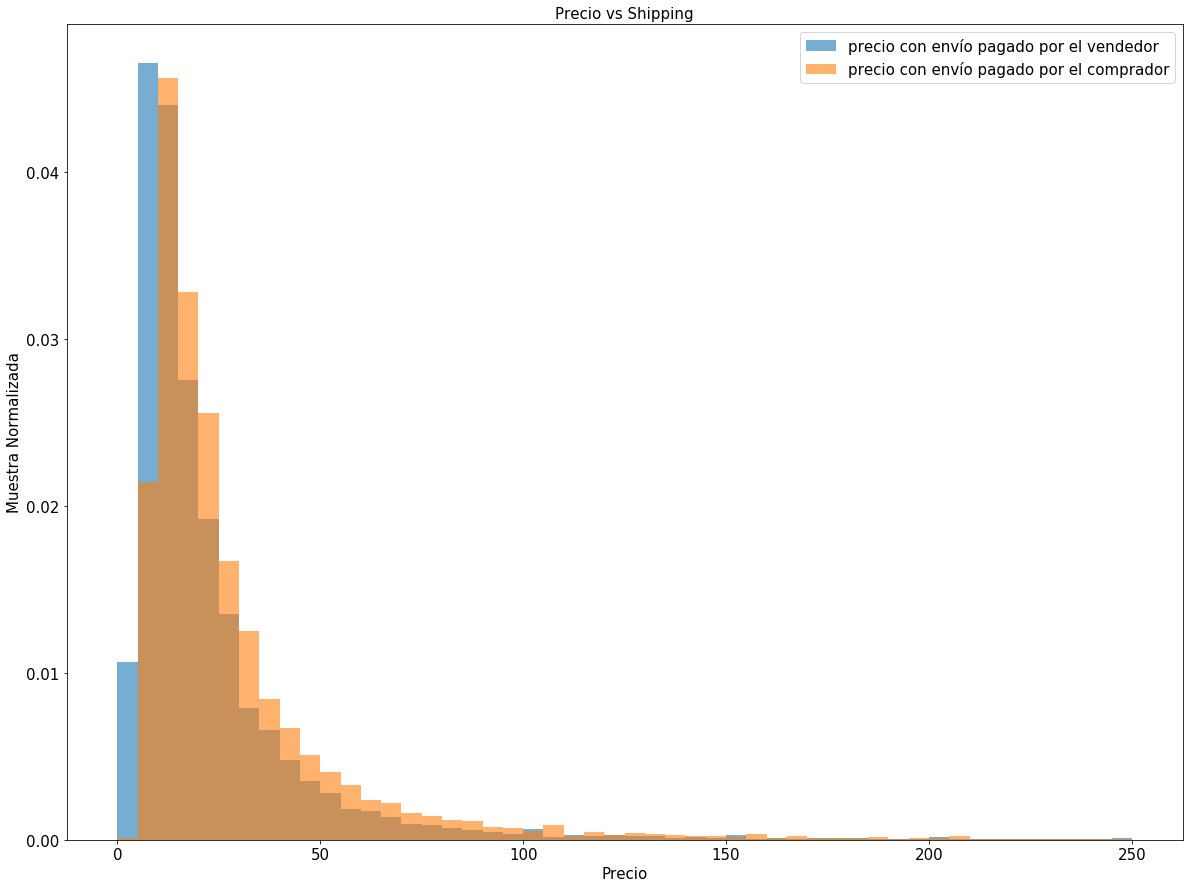

In [97]:
plt.figure(figsize=(20, 15))
bins=50
plt.hist(train_2[train_2['shipping']==1]['price'], bins, normed=True, range=[0,250],
         alpha=0.6, label='precio con envío pagado por el vendedor')
plt.hist(train_2[train_2['shipping']==0]['price'], bins, normed=True, range=[0,250],
         alpha=0.6, label='precio con envío pagado por el comprador')
plt.title('Precio vs Shipping', fontsize=15)
plt.xlabel('Precio', fontsize=15)
plt.ylabel('Muestra Normalizada', fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
La diferencia de quien paga el envío parece no afectar significativamente a la distribución del precio. Las cantidad de artículos por condiciones de pago de envío tienen similar proporción.


In [ ]:
9. ¿Qué relación tiene la descripción del producto con el precio?

(-0.5, 1439.5, 1079.5, -0.5)

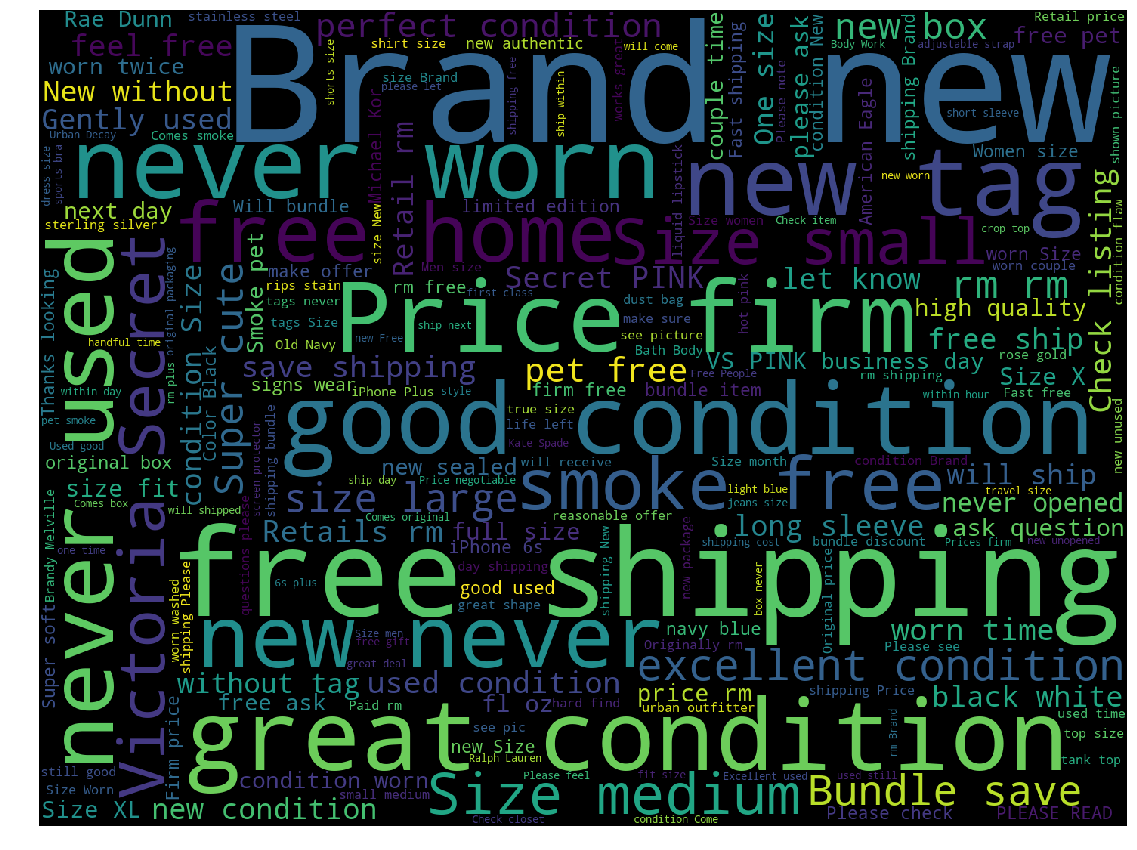

In [117]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_2['item_description'].unique().astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')


In [119]:
train_2['Con_descr'] = 1
train_2.loc[train_2['item_description']=='No description yet', 'Con_descr'] = 0

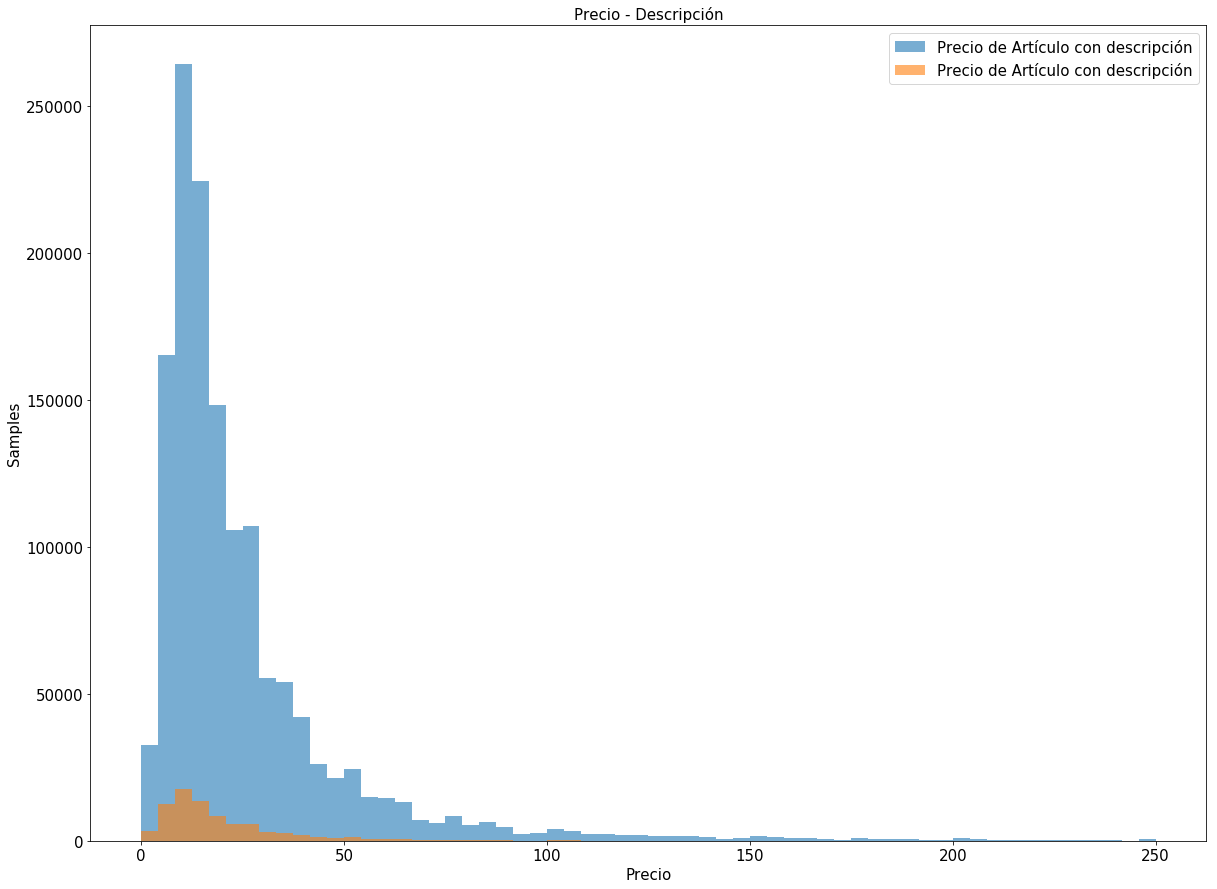

In [121]:
plt.figure(figsize=(20, 15))
bins=60
plt.hist(train_2[train_2['Con_descr']==1]['price'], bins, range=[0,250],
         alpha=0.6, label='Precio de Artículo con descripción')
plt.hist(train_2[train_2['Con_descr']==0]['price'], bins, range=[0,250],
         alpha=0.6, label='Precio de Artículo sin descripcióPrecio de Artículo sin descripción')
plt.title('Precio - Descripción', fontsize=15)
plt.xlabel('Precio', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

Se observa que los precios de artículos con descripción y sin descripción siguen una distribución similar. Esto se ve de forma más clara en el histograma normalizado
. Por lo que podriamos deducir que la tenencia de descripción no tiene gran impacto en el precio.

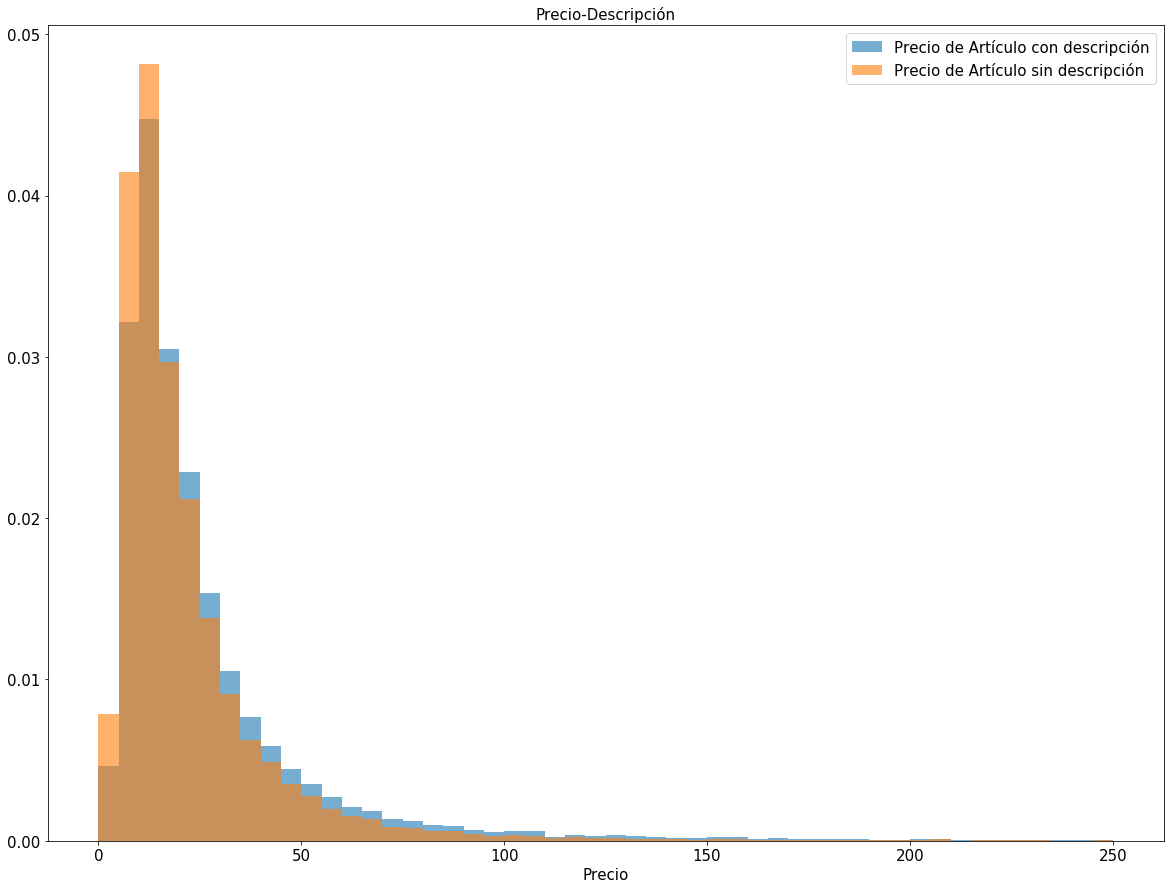

In [123]:
plt.figure(figsize=(20, 15))
bins=50
plt.hist(train_2[train_2['Con_descr']==1]['price'], bins, normed=True,range=[0,250],
         alpha=0.6, label='Precio de Artículo con descripción')
plt.hist(train_2[train_2['Con_descr']==0]['price'], bins, normed=True,range=[0,250],
         alpha=0.6, label='Precio de Artículo sin descripción')
plt.title('Precio-Descripción', fontsize=15)
plt.xlabel('Precio', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

10.- ¿Cuáles son las marcas populares por categorías? ¿Cómo se relaciona la marca con el precio?

In [165]:
print("Hay %d marcas únicas en el listado." % train_2['brand_name'].nunique())
print ("Las 20 categorias más populares son:")
pd.value_counts(train_2.brand_name).sort_values(ascending=False).head(20)


Hay 4810 marcas únicas en el listado.
Las 20 categorias más populares son:


NoBrand              632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Apple                 17322
FOREVER 21            15186
Nintendo              15007
Lululemon             14558
Michael Kors          13928
American Eagle        13254
Rae Dunn              12305
Sephora               12172
Coach                 10463
Disney                10360
Bath & Body Works     10354
Adidas                10202
Funko                  9237
Under Armour           8461
Sony                   7994
Name: brand_name, dtype: int64